# How to measure energy of particles experimentally?

In particle physics, Calorimeters are particle detectors that measure the energy of a particle. When particles passes through matter, it create a shower of secondary particles (Read more at https://en.wikipedia.org/wiki/Particle_shower) and deposits energy. The deposited energy is then recorded by the read out electronics and corrected depending how much energy has been sampled.


# Hadronic Calorimeter detector 

The hadronic calorimeter is designed for future sPHENIX experiment. It is a steel-scintillator sampling calorimeter with two longitudinal segments, the inner and outer HCal. More details can be found at https://arxiv.org/abs/1704.01461. The purpose of this notebook is to focus on data analysis in python.

Below is an analysis of the data collected by a Hadronic calorimeter prototype at Fermi National Laboratory, Chicago. The full detector is designed to be 100 times bigger than this prototype and will be a part of sPHENIX experiment at Brookhaven National Laboratory. The prototype had total 32 towers in two longitudinal segments of 4x4 array.

<img src='hcal_drawing.png' style="width: 40%; height: 40%">

Most of these codes were originally written in C++ with ROOT data analysis software (https://root.cern.ch/). Below is a demonstration in python. Git repository for the C++ version of the data analysis software can be found at:
https://github.com/sPHENIX-Collaboration/analysis/tree/master/Prototype2/HCAL/ShowerCalib

# Data Format
Data was collected at a test beam facility at Fermi National Laboratory in Chicago. The test beam is a mixture of hadron and electron particles. The purpose of the Hadronic Calorimeter is to measure the energy of hadronic showers. The energy of the incoming particle is known but not its species. There is an additional detector available at the test beam facility called Cherenkov detector (https://en.wikipedia.org/wiki/Cherenkov_detector). Electrons passed through Cherenkov detector emits a high signal while hadrons dont. Some terminology:
1. Event: Each event is one incident particle to our experimental setup. At the end of each event read out electronics records the signal from all the detector sensors and dumps to disk. Each row in the Pandas dataframe below corresponds to one event collected.
2. Run: A collection of events with a particular setup of the experiment.
3. Beam momentum: The energy of the incoming particle.
4. C2_sum: Signal from the Cherenkov detector. High signal indicate electron, otherwise it is a hadron. Sometimes electrons get missed by the detector rising a contamination in hadron sample.
5. hcalin_twr_e: The inner HCal tower energies. 16 read outs from 4x4 towers.
6. hcalout_twr_e: The outer HCal tower energies. 16 read outs from 4x4 towers.


# Objectives
1. Data exploration.
2. Understanding detector performance for hadron and electrons separately.
3. Optimize the tower weights numerically for a better performance.
4. Build a classification model for hadron and electron separation.
5. Dimention reduction and visualize the data in lower dimention.
6. Clustering to find hidden patterns in the data.

I originally had data in ROOT files. root_numpy module provides an interface between ROOT and numpy (https://pypi.python.org/pypi/root_numpy). Lets start with 16 GeV data file and at the end we will look at all energies together. 


In [1]:
from root_numpy import tree2array
from ROOT import TFile
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import leastsq
import seaborn as sns
import operator as op
from scipy import stats
from scipy.optimize import minimize

filename = 'Prototype_pionn_16.root'
rfile = TFile(filename)
intree = rfile.Get('T')
variables = ['run','beam_mom','C2_sum','hcalin_twr_e','hcalout_twr_e']
myarray = tree2array(intree,branches=variables)
df = pd.DataFrame(myarray.tolist(), columns=variables)
df.shape

Welcome to ROOTaaS 6.06/08


TClass::Init:0: RuntimeWarning: no dictionary for class Proto2ShowerCalib::Eval_Run is available
TClass::Init:0: RuntimeWarning: no dictionary for class Proto2ShowerCalib::HCAL_shower is available


(167204, 5)

In [10]:
df.head()

,run,beam_mom,C2_sum,hcalin_twr_e,hcalout_twr_e
0,3730,-16.0,-0.019210,"[-0.00265980022959, -0.00462330272421, -0.0037...","[-0.0212302021682, -0.0184601247311, 0.0162082..."
1,3730,-16.0,-0.551397,"[-0.00691356416792, 0.00586697971448, 0.003307...","[0.010158309713, 0.0527120679617, 0.8358482718..."
2,3730,-16.0,359.499847,"[0.00296210846864, 0.0130761666223, 0.01332342...","[0.0144229764119, 0.00840053055435, -0.0099206..."
3,3730,-16.0,-2.053645,"[0.0166303664446, 0.0260916631669, 0.040534138...","[0.0170602612197, -0.0147548737004, 0.02767019..."
4,3730,-16.0,1.471208,"[-0.00317231588997, -0.00269385124557, 0.00277...","[0.0223745349795, -0.0149723319337, -0.0114196..."


Lets start with "C2_sum" variable. It is the signal from Cherenkov detector.

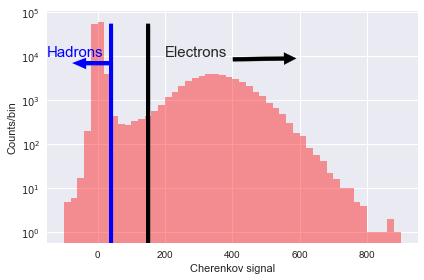

In [83]:
fig = sns.distplot(df['C2_sum'],hist=True, kde=False, hist_kws={"range": [-100,900]}, color='red')
plt.gca().set_yscale('log')
plt.xlabel("Cherenkov signal")
plt.ylabel("Counts/bin")
plt.annotate('Electrons', xy=(600, 9e3), xytext=(200, 1e4), fontsize=15,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.arrow(150, 0, 0, 5e4, head_width=0, head_length=0, color='black', lw=4)
plt.text(-150,1e4,r"Hadrons",fontsize=15, color='blue')
plt.arrow(40, 0, 0, 5e4, head_width=0, head_length=0, color='blue', lw=4)
plt.arrow(40, 7e3, -80, 0, head_width=2000, head_length=20, color='blue', lw=4)

As you can see above Cherenkov detector has a broad signal above 150 counts for electrons. Event with no signal close to zero are hadrons. You might ask why the signal is negative? It is because of the noise. A physicist/engineer would call it the pedestal flactuations. "Pedestal" means the measured value of an electrical component when no input signal is given. We define two new variables "good_e" and "good_h" when Cherenkov signal >150 and <20. For the signal in between we are not sure.

Lets look into our calorimeter data. Sum all 4x4 towers for inner and outer HCal separately. Two new variables are introduced "hcalin_sum" and "hcalout_sum". Some of the values for "hcalin_twr_e" and "hcalout_twr_e" are negative. Thats perfectly alright, it is called pedestal flactuation.

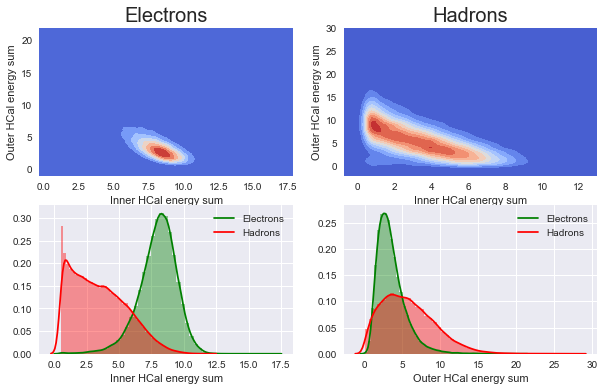

In [2]:
df['good_e'] = df['C2_sum'].apply( lambda x: x>150)
df['good_h'] = df['C2_sum'].apply( lambda x: x<20 )

df['hcalin_sum'] = df['hcalin_twr_e'].apply(lambda x: sum(x))
df['hcalout_sum'] = df['hcalout_twr_e'].apply(lambda x: sum(x))

df = df[df['hcalin_sum']>0.5]
df = df[df['hcalout_sum']>0]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6))
#plot electrons
plot_data = df[df['good_e']]
sns.kdeplot(plot_data["hcalin_sum"], plot_data["hcalout_sum"], shade=True, cut=5, cmap='coolwarm', ax=ax1)
ax1.set_xlabel("Inner HCal energy sum")
ax1.set_ylabel("Outer HCal energy sum")
ax1.set_title("Electrons",fontsize=20)
sns.distplot(plot_data['hcalin_sum'], color='green', kde_kws={"label": "Electrons"}, ax=ax3)
sns.distplot(plot_data['hcalout_sum'], color='green', kde_kws={"label": "Electrons"}, ax=ax4)

#plot Hadrons
plot_data = df[df['good_h']]
sns.kdeplot(plot_data["hcalin_sum"], plot_data["hcalout_sum"], shade=True, cut=5, cmap='coolwarm', ax=ax2)
ax2.set_xlabel("Inner HCal energy sum")
ax2.set_ylabel("Outer HCal energy sum")
ax2.set_title("Hadrons",fontsize=20)
sns.distplot(plot_data['hcalin_sum'], color='red', kde_kws={"label":"Hadrons"}, ax=ax3)
ax3.set_xlabel("Inner HCal energy sum")
sns.distplot(plot_data['hcalout_sum'], color='red', kde_kws={"label":"Hadrons"}, ax=ax4)
ax4.set_xlabel("Outer HCal energy sum")

The above shows how the energy is distributed between two segments of the calorimeter. We learn something fundamental about electromagnetic and hadronic showers. Electrons deposit most of the energies in the inner segment while hadrons deposits most of energies in the outer segment. 

Lets make a new variable which is the asymmetry between the two segments.

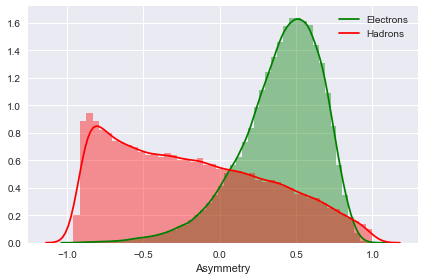

In [229]:
df['Asymmetry'] = df.apply(lambda x:(x['hcalin_sum']-x['hcalout_sum'])/(x['hcalin_sum']+x['hcalout_sum']), axis=1)

sns.distplot(df[df['good_e']]['Asymmetry'], color='green', kde_kws={"label": "Electrons"})
sns.distplot(df[df['good_h']]['Asymmetry'], color='red', kde_kws={"label": "Hadrons"})

As expected electrons deposit most of energies in the inner HCal, hence asymmetry close to 1. Hadrons on the other hand is shared.

Lets look into which towers contain most of the energies. We can look into a heatmap of the 4x4 towers.

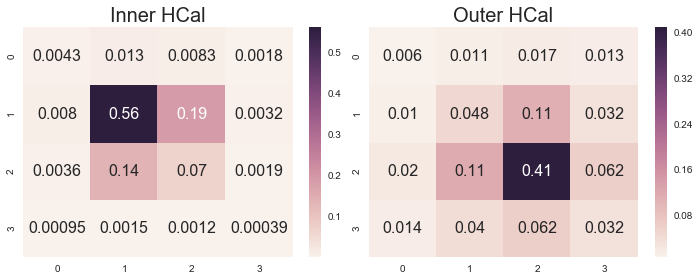

In [114]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
hcalin_twr_sum = df['hcalin_twr_e'].sum()
hcalin_twr_sum = hcalin_twr_sum/sum(hcalin_twr_sum)
sns.heatmap(hcalin_twr_sum.reshape(4,4),annot=True, annot_kws={"size": 16}, ax=ax1)
ax1.set_title("Inner HCal", fontsize=20)

hcalout_twr_sum = df['hcalout_twr_e'].sum()
hcalout_twr_sum = hcalout_twr_sum/sum(hcalout_twr_sum)
sns.heatmap(hcalout_twr_sum.reshape(4,4),annot=True, annot_kws={"size": 16}, ax=ax2)
ax2.set_title("Outer HCal", fontsize=20)

So most of energy is deposited in one tower. This is expected because beam was narrow enough and setup of the experiment didn't change while data taking.

Now lets look into the total energy, combining both the sections.

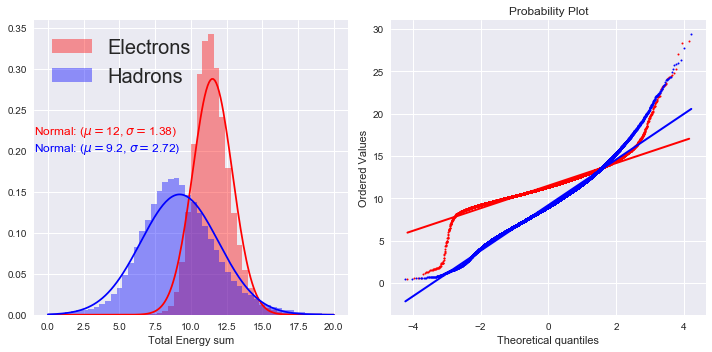

In [193]:
#df = df[df.good_e+df.good_h==1]
df['sum_e'] = df['hcalin_sum'] + df['hcalout_sum']

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
#for electrons
sns.distplot(df[df['good_e']]['sum_e'], kde=False, color='red', fit=stats.norm,  label="Electrons", hist_kws={"range":[0,20]}, fit_kws={"clip":[0,20],"color":'red'},  ax=ax1)
(mu, sigma) = stats.norm.fit(df[df['good_e']]['sum_e'])
ax1.text(-1., 0.22, "Normal: ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma),fontsize=12, color='red')
res = stats.probplot(df[df['good_e']]['sum_e'], plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('r')
ax2.get_lines()[0].set_markersize(2.0)
ax2.get_lines()[1].set_linewidth(2.0)

#for hadrons
sns.distplot(df[df['good_h']]['sum_e'], kde=False, color='blue', fit=stats.norm, label="Hadrons", hist_kws={"range":[0,20]}, fit_kws={"clip":[0,20],"color":'blue'}, ax=ax1)
ax1.legend(loc='best', fontsize=20)
(mu, sigma) = stats.norm.fit(df[df['good_h']]['sum_e'])
ax1.text(-1., 0.20, "Normal: ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma),fontsize=12, color='blue')
ax1.set_xlabel("Total Energy sum")
res = stats.probplot(df[df['good_h']]['sum_e'], plot=ax2)
ax2.get_lines()[2].set_markerfacecolor('b')
ax2.get_lines()[2].set_markersize(2.0)
ax2.get_lines()[3].set_color('b')
ax2.get_lines()[3].set_linewidth(2.0)


On the left plot above now we can see the individual peaks for electrons and hadrons. Electron peak is slightly higher than hadrons and it is expected. It is intrinsic to the detector material. In physics it is called e/h response and always more than 1. Another important observation is the width of the hadron showers is higher than the electron showers. This is also a well known fact in physics community. So far so good.

However recall this data is for 16 GeV input energy. The means for both particles are not even close to where they should be. This is because data needs to calibrate. Due to inconsistencies in detector material, electronics, dust and other physical reasons the response of the individual towers are not exactly the same. So we need to equalize the tower responses. One way to do it is to get a set of weights for all the towers and optimize the energy response. This process is slower, so we will optimize over 1000 good hadron samples. The idea is to minimize the difference between input and reconstructed energy.

      fun: 798.504855050277
 hess_inv: array([[ 1.34252518,  0.91705428,  1.44299419, ...,  0.18648454,
         0.22337187, -0.32985478],
       [ 0.91705428,  0.86826752,  1.26759327, ...,  0.1480557 ,
         0.19196953, -0.30243625],
       [ 1.44299419,  1.26759327,  2.48158973, ...,  0.27512873,
         0.33636833, -0.52238864],
       ..., 
       [ 0.18648454,  0.1480557 ,  0.27512873, ...,  0.05996731,
         0.03911392, -0.06095598],
       [ 0.22337187,  0.19196953,  0.33636833, ...,  0.03911392,
         0.06496049, -0.07922111],
       [-0.32985478, -0.30243625, -0.52238864, ..., -0.06095598,
        -0.07922111,  0.14214093]])
      jac: array([ -5.34057617e-05,  -6.86645508e-05,   7.62939453e-05,
        -3.05175781e-05,   7.62939453e-06,  -2.28881836e-05,
         2.28881836e-05,   5.34057617e-05,  -7.62939453e-05,
         6.86645508e-05,  -9.15527344e-05,   2.28881836e-05,
        -6.10351562e-05,  -1.52587891e-05,  -5.34057617e-05,
         0.00000000e+00,  -1.90

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


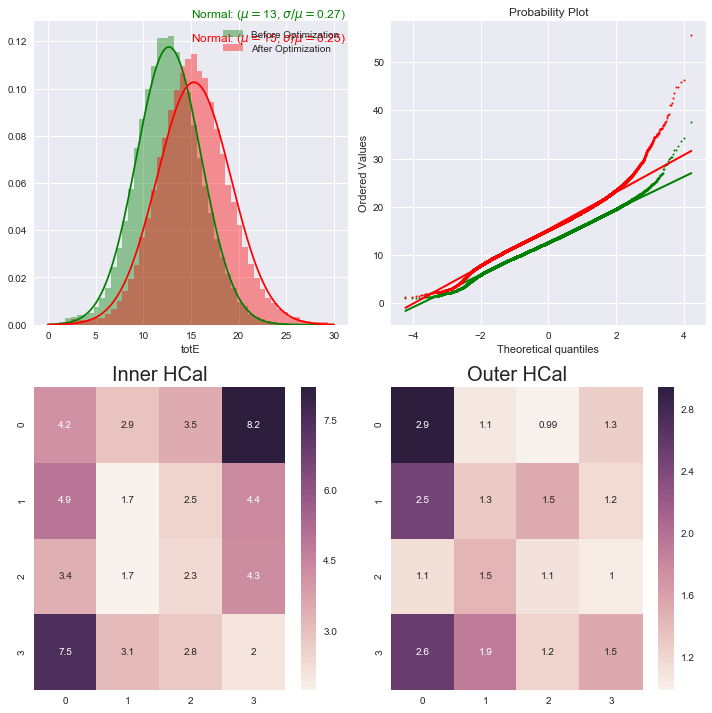

In [223]:
import math
dfs = df[df['good_h']][:1000]
#dfs = dfs[dfs['sum_e']>5][:1000]
c = [1. for i in xrange(32)]

def optfunc(E,hin_twr_e,hout_twr_e,weights):
    hin_e = sum(map(op.mul,hin_twr_e,weights[:16]))
    hout_e= sum(map(op.mul,hout_twr_e,weights[16:]))
    return (hin_e + hout_e + E)**2/math.fabs(E)

#finally_apply
def final_apply(row,weights):
    hin_e = sum(map(op.mul,row['hcalin_twr_e'],weights[:16]))
    hout_e= sum(map(op.mul,row['hcalout_twr_e'],weights[16:]))
    return hin_e + hout_e

def minfunc(c):
    return sum(dfs.apply(lambda x: optfunc(x['beam_mom'],x['hcalin_twr_e'],x['hcalout_twr_e'],c),axis=1))
    #corr_energy = df.apply(final_apply,weights=c,axis=1)
    #return corr_energy.std()/corr_energy.mean()
    
#bnds = [(0,3) for i in xrange(32)]
#scipy.optimize.minimize(fun, x0, args=(), method='BFGS', jac=None, tol=None, callback=None, options={'disp': False, 'gtol': 1e-05, 'eps': 1.4901161193847656e-08, 'return_all': False, 'maxiter': None, 'norm': inf})

result = minimize(minfunc,c)
print result

df['sum_e'] = 2*df['hcalin_sum'] + df['hcalout_sum']
all_h = df[df['good_h']]
all_h['totE'] = all_h.apply(final_apply,weights=result.x,axis=1)


f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10,10))
sns.distplot(all_h['sum_e'], kde=False, color='green', fit=stats.norm,  label="Before Optimization", hist_kws={"range":[0,30]}, fit_kws={"clip":[0,30],"color":'green'},  ax=ax1)
(mu, sigma) = stats.norm.fit(all_h['sum_e'])
ax1.text(15, 0.13, "Normal: ($\mu=${0:.2g}, $\sigma/\mu=${1:.2f})".format(mu, sigma/mu),fontsize=12, color='green')

res = stats.probplot(all_h['sum_e'], plot=ax2)
ax2.get_lines()[0].set_markerfacecolor('green')
ax2.get_lines()[0].set_markersize(2.0)
ax2.get_lines()[1].set_linewidth(2.0)
ax2.get_lines()[1].set_color('green')

sns.distplot(all_h['totE'], kde=False, color='red', fit=stats.norm,  label="After Optimization", hist_kws={"range":[0,30]}, fit_kws={"clip":[0,30],"color":'red'},  ax=ax1)
(mu, sigma) = stats.norm.fit(all_h['totE'])
ax1.text(15, 0.12, "Normal: ($\mu=${0:.2g}, $\sigma/\mu=${1:.2f})".format(mu, sigma/mu),fontsize=12, color='red')
ax1.legend(loc='best', fontsize=10)

res = stats.probplot(all_h['totE'], plot=ax2)
ax2.get_lines()[2].set_markerfacecolor('r')
ax2.get_lines()[2].set_markersize(2.0)
ax2.get_lines()[3].set_linewidth(2.0)

#plt.subplot(1,3,2)
sns.heatmap(result.x[:16].reshape(4,4),annot=True, ax=ax3)
ax3.set_title("Inner HCal", fontsize=20)

#plt.subplot(1,3,3)
sns.heatmap(result.x[16:].reshape(4,4),annot=True, ax=ax4)
ax4.set_title("Outer HCal", fontsize=20)


After optimization it looks much better. The mean is where is expected to be. Sigma/mean is also decreased. The optimization code runs much slower in python. I have a C++ version which runs over all the data pretty quickly. The abover excercise shows how scipy.optimize can be used for weights optimization.

Next we are goint to try some classification. The Cherenkov detector is not part of our experiment design, it is an external device provided from the test beam facility. In our experiment we have to distinguish a hadron event from an electron event by looking into how energy deposited in our detector only.

BEST PARAMS {}
Accuracy on training data: 0.94
Accuracy on test data:     0.89
[[91 12]
 [10 87]]
BEST PARAMS {}
Accuracy on training data: 0.93
Accuracy on test data:     0.94
[[112   6]
 [  7  75]]
BEST PARAMS {}
Accuracy on training data: 0.90
Accuracy on test data:     0.90
[[98 13]
 [ 7 82]]
BEST PARAMS {'min_samples_leaf': 0.05}
Accuracy on training data: 0.88
Accuracy on test data:     0.92
[[109   9]
 [  8  74]]


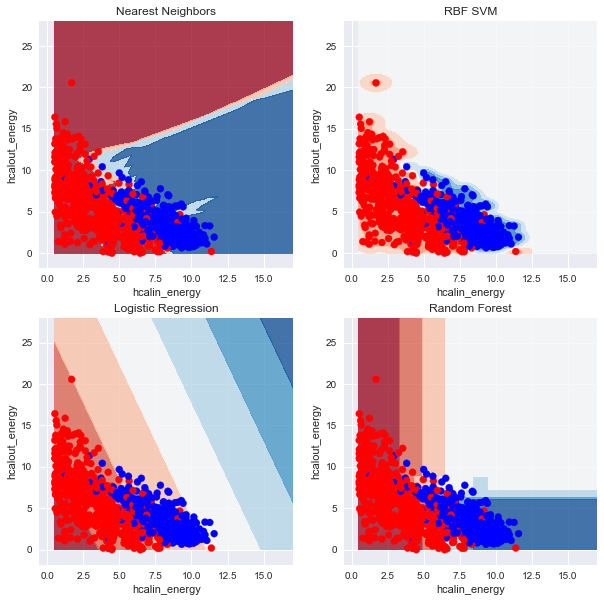

In [6]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import manifold
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=indf[targetname].values
    y = y.reshape((len(y)))
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    #ypred = clf.predict(X)
    return clf #, ypred


df = df[df.good_e+df.good_h==1]
dfs = df.sample(1000)

xcolumns = ['hcalin_sum','hcalout_sum']
target = ['good_e']

names = ["Nearest Neighbors", "RBF SVM", "Logistic Regression", "Random Forest"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(gamma=2, C=1),
    LogisticRegression(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    ]

param_grids = [
    {},
    {},
    {"C": [0.01, 0.1, 1, 10, 100]},
    {"min_samples_leaf": [0.05, 0.10, 0.20, 0.30]},
]

figure = plt.figure(figsize=(10, 10))
for i, (name, clf, par) in enumerate(zip(names,classifiers,param_grids)):
    clf_fit = do_classify(clf, par, dfs, xcolumns, target)
    ax = plt.subplot(2, 2, i+1)
    ax.set_title(name)
    xx, yy = np.meshgrid(np.arange(df['hcalin_sum'].min(),df['hcalin_sum'].max(),0.01),
                         np.arange(df['hcalout_sum'].min(),df['hcalout_sum'].max(),0.01))
    if hasattr(clf, "decision_function"):
        Z = clf_fit.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf_fit.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.contourf(xx,yy,Z,cmap=cm,alpha=0.8)
    ax.scatter(dfs['hcalin_sum'], dfs['hcalout_sum'], c=dfs['good_e'], cmap=cm_bright)
    ax.set_xlabel('hcalin_energy')
    ax.set_ylabel('hcalout_energy')

In [ ]:
#Clustering


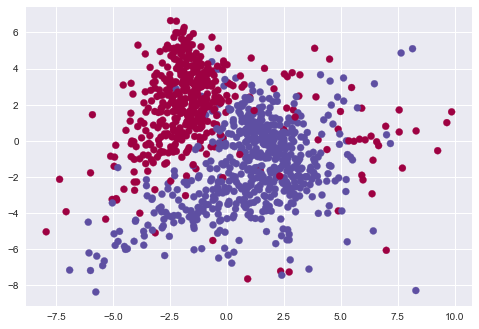

In [6]:
#Lets try dimention reduction
from sklearn.manifold import MDS

colnames = ['hcalin_twr_%i'%i for i in xrange(16)]
colnames.extend(['hcalout_twr_%i'%i for i in xrange(16)])
df = df[(df['good_h']) | (df['good_e'])]

def flatten_columns(row):
    cols = {}
    for i in xrange(16):
        cols[colnames[i]] = row['hcalin_twr_e'][i]
        cols[colnames[i+16]] = row['hcalout_twr_e'][i]
    cols['good_h'] = row['good_h']
    return pd.Series(cols)

df_flat = df.apply(flatten_columns,axis=1)
df_flat.head()

X = df_flat[colnames]
y = df_flat['good_h']

mds = MDS(n_components=2, max_iter=100, n_init=1)
df_trans = mds.fit_transform(X)

plt.scatter(df_trans[:, 0], df_trans[:, 1], c=y.values,cmap=plt.cm.Spectral)